In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Tuple
from antea.elec import tof_functions as wvf 
from scipy import signal
#import fit_library as ftl
%matplotlib nbagg
%reload_ext autoreload
%autoreload 2

In [2]:
# Time unit (tu) -> 100 ps
# Simulation Time Step -> 5ns (50 tu)
time_unit = 100E-12
time_step = 1 #tu
pe_density = 200 / 5000 #tu
pe_peak = 20.9 #uA
SiPM_gain = 1.04E-12 #pC
n_pe_total = 750
delay = 2000

In [3]:
# Waveform generator
def wave_gen(pe_time_zs:np.array) -> Tuple[np.array,np.array,np.array]:
    
    spe_response_norm_Q,norm = wvf.apply_spe_dist(np.arange(0,4000),[10,500])
    spe_response = spe_response_norm_Q*SiPM_gain/time_unit # current conversion
    time = np.arange(0,pe_time_zs[0,-1]*time_step+len(spe_response))
    pe   = np.zeros(pe_time_zs[0,-1].astype('int')*time_step+len(spe_response)) 
    pe[pe_time_zs[0,:].astype('int')*time_step] = pe_time_zs[1,:]  
    
    # C. Romo convolution
    #wave = wvf.convolve_tof(spe_response,pe)
    wave = np.convolve(spe_response,pe)
    return time,wave,pe

# SPE SHAPE

<IPython.core.display.Javascript object>


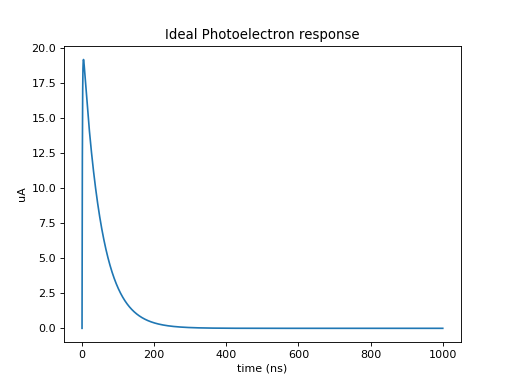

SPE Value in pC = 1.04
SPE Value Normalized = 1.00


Text(0.5, 1.0, 'Ideal Photoelectron response')

In [4]:
plt.figure()
#plt.plot(TIME_rnd)
spe_response,norm = wvf.apply_spe_dist(np.arange(0,10000),[10,500])
spe_signal = SiPM_gain/time_unit*spe_response
# This is an aproximation, Exponential decay integral equals height*TAU. Since spe_response is normalized to 1
plt.plot(np.arange(0,1000,0.1),spe_signal/1E-6)
print(("SPE Value in pC = %2.2f") % (np.sum(spe_signal)*time_unit/1E-12))
print(("SPE Value Normalized = %2.2f") % (np.sum(spe_response)))
plt.xlabel("time (ns)")
plt.ylabel("uA")
plt.title("Ideal Photoelectron response")

# Simple Shaping (RC)

<IPython.core.display.Javascript object>


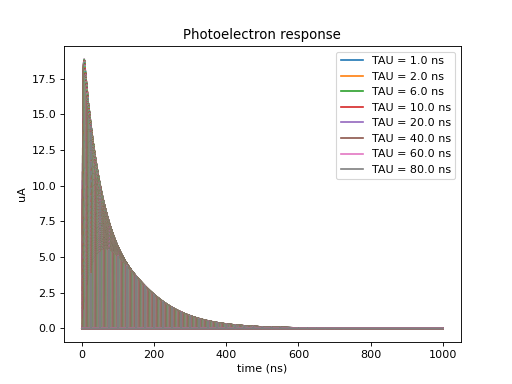

Normalized SPE value after shaping = 1.0000


In [5]:
TAU_v = [10, 20, 60, 100, 200, 400, 600, 800] #(10 ns Shaping Time)

plt.figure()

for TAU in TAU_v:
    f_sample = (1/time_unit); # Hz
    freq_LPF = 1/(TAU*time_unit);   # 50E6*2*np.pi; # rad/sec
    freq_LPFd = freq_LPF / (f_sample*np.pi); # Normalized by Nyquist Freq (half-cycles/sample)
    # Filter Definitions
    b, a = signal.butter(1, freq_LPFd, 'low', analog=False)
    signal_out = signal.lfilter(b,a,spe_signal)

    plt.plot(np.arange(0,1000,0.1),signal_out/1E-6, label=("TAU = %1.1f ns") % (TAU/10))
    #print(np.sum(signal_out)*time_unit)
    plt.xlabel("time (ns)")
    plt.ylabel("uA")
    plt.title("Photoelectron response")
    plt.legend()

print("Normalized SPE value after shaping = %1.4f" % (np.sum(signal_out)*time_unit/SiPM_gain))

# Signal Amplitude and Time Sampling effects (assuming INFN Front-End)

<IPython.core.display.Javascript object>


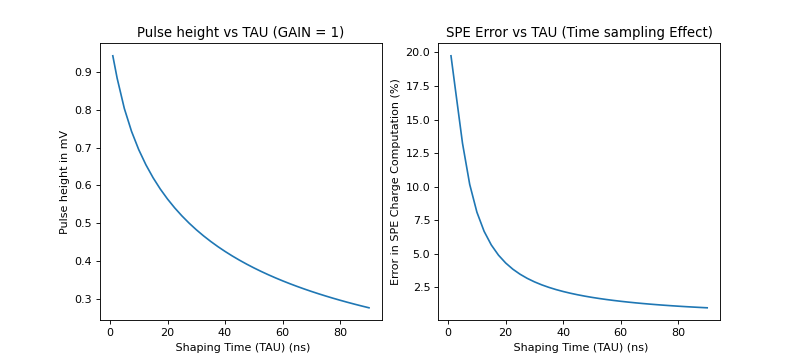

Text(0.5, 1.0, 'SPE Error vs TAU (Time sampling Effect)')

In [6]:
DAQ_sample_freq = 250;  # 40 MHz 
tau_shaping = [10, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 
               350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700,
               725, 750, 775, 800, 825, 850, 875, 900] # 0.1n time unit
error_array = np.zeros(250)
error_vs_shaping = np.zeros(len(tau_shaping))
peak_vs_shaping = np.zeros(len(tau_shaping))

count = 0
for TAU in tau_shaping:
    
    f_sample = (1/time_unit); # Hz
    freq_LPF = 1/(TAU*time_unit);   # 50E6*2*np.pi; # rad/sec
    freq_LPFd = freq_LPF / (f_sample*np.pi); # Normalized by Nyquist Freq (half-cycles/sample)
    # Filter Definitions
    b, a = signal.butter(1, freq_LPFd, 'low', analog=False)
    signal_out = signal.lfilter(b,a,spe_signal)

    
    for phase_shift in np.arange(1,DAQ_sample_freq+1):

        signal_out_sampled = signal_out[phase_shift:-1:DAQ_sample_freq] # 40MHz sampled signal
        signal_out_resampled = np.zeros(10000);
        signal_out_resampled[phase_shift:-1:DAQ_sample_freq] = signal_out_sampled;
        plt.plot(np.arange(0,1000,0.1),signal_out_resampled/1E-6)
        n_pe_recovered_after_sampling=np.sum(signal_out_sampled)*(time_unit*250)/SiPM_gain
        error_array[phase_shift-1]=1-n_pe_recovered_after_sampling

    error_vs_shaping[count] = np.max(abs(error_array)) * 100
    peak_vs_shaping[count] = np.max(signal_out) * 50 / 1E-3
    count = count + 1
    #print(("%2.2f%%") % (max_error*100))    

fig = plt.figure(figsize=(10,4.5))
axis1 = fig.add_subplot(121)
axis2 = fig.add_subplot(122)
axis1.plot(np.array(tau_shaping)/10, peak_vs_shaping)
axis1.set_xlabel(" Shaping Time (TAU) (ns)")
axis1.set_ylabel("Pulse height in mV")
axis1.set_title("Pulse height vs TAU (GAIN = 1)")
axis2.plot(np.array(tau_shaping)/10, error_vs_shaping)
axis2.set_xlabel(" Shaping Time (TAU) (ns)")
axis2.set_ylabel("Error in SPE Charge Computation (%)")
axis2.set_title("SPE Error vs TAU (Time sampling Effect)")

    


# FE Gain and Amplitude Quantization Effects (same conditions)

In [7]:

def quantize(in_value,q_vector):
    return max(q_vector[in_value>=q_vector])

<IPython.core.display.Javascript object>


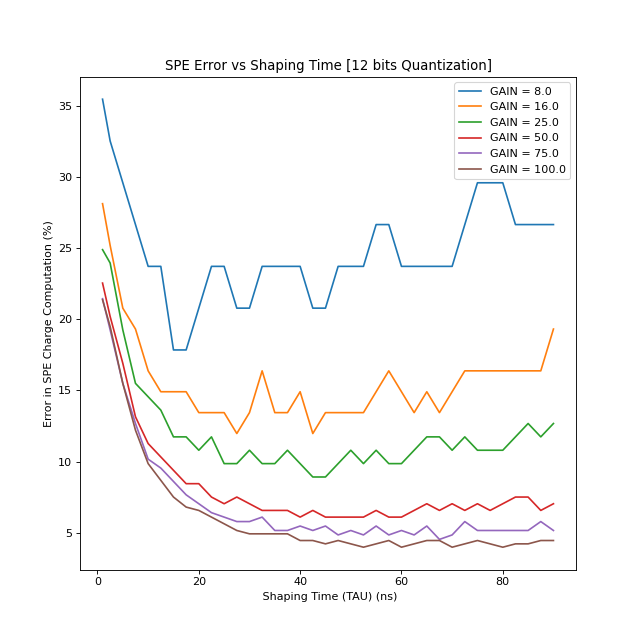

In [9]:

DAQ_sample_freq = 250;  # 40 MHz 
DAQ_LSB = 2 / 2**12 # 12 bits over 2V fullscale
error_array = np.zeros(250)

GAIN_v = [8,16,25,50,75,100]

tau_shaping = [10, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 
               350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700,
               725, 750, 775, 800, 825, 850, 875, 900] # 0.1n time unit

q_vector = np.arange(0,2,DAQ_LSB)
error_vs_shaping_q = np.zeros(len(tau_shaping))


#fig = plt.figure(figsize=(10,5))

fig = plt.figure(figsize=(8,8))
axis1 = fig.add_subplot(111)
axis1.set_xlabel(" Shaping Time (TAU) (ns)")
axis1.set_ylabel("Error in SPE Charge Computation (%)")
axis1.set_title("SPE Error vs Shaping Time [12 bits Quantization]")

for GAIN in GAIN_v:
    
    pe_value_V = np.sum(spe_signal * 50 * GAIN)*(time_unit)
    
    count = 0
    
    for TAU in tau_shaping:

        f_sample = (1/time_unit); # Hz
        freq_LPF = 1/(TAU*time_unit);   # 50E6*2*np.pi; # rad/sec
        freq_LPFd = freq_LPF / (f_sample*np.pi); # Normalized by Nyquist Freq (half-cycles/sample)
        # Filter Definitions
        b, a = signal.butter(1, freq_LPFd, 'low', analog=False)   

        FE_out_wave_v = signal.lfilter(b,a,spe_signal) * 50 * GAIN


        for phase_shift in np.arange(1,DAQ_sample_freq+1):

            FE_out_wave_v_sampled = FE_out_wave_v[phase_shift:-1:DAQ_sample_freq] # 40MHz sampled signal

            FE_out_wave_v_Q = np.zeros(len(FE_out_wave_v_sampled))

            for t_sample in np.arange(len(FE_out_wave_v_sampled)):
                FE_out_wave_v_Q[t_sample] = quantize(FE_out_wave_v_sampled[t_sample],q_vector)

            #FE_out_wave_v_resampled = np.zeros(10000); # 1 microsecond
            #FE_out_wave_v_resampled[phase_shift:-1:DAQ_sample_freq] = FE_out_wave_v_Q;        
            #plt.plot(np.arange(0,1000,0.1),FE_out_wave_v_resampled)

            n_pe_recovered = np.sum(FE_out_wave_v_Q)*(time_unit*DAQ_sample_freq)/pe_value_V        
            error_array[phase_shift-1]=1-n_pe_recovered

        error_vs_shaping_q[count] = np.max(abs(error_array)) * 100

        count = count + 1

    axis1.plot(np.array(tau_shaping)/10, error_vs_shaping_q,label=("GAIN = %1.1f") % (GAIN))

axis1.legend()



In [ ]:
print(np.arange(0,2,DAQ_LSB))

In [ ]:
quantize(0,np.arange(0,2,DAQ_LSB))